In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import os
import sys

In [3]:
os.chdir('/content/drive/MyDrive/Test_case/Figures_detection/detecror_training_2/')
sys.path.append('/content/drive/MyDrive/Test_case/Figures_detection')
sys.path.append('/content/drive/MyDrive/Test_case')

In [4]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as F
from tqdm import tqdm
from utils.loss import lossYolov1
from yolov_1_model import YOLO_model
from detecror_training_2.utils.metrics import *
from detecror_training_2.utils.utils import save_checkpoint, load_checkpoint, update_dataset_info
from detecror_training_2.utils.dataloaders import  ShapeDatasetFromGenerator
import pandas as pd
import pickle
from torch.utils.data import DataLoader
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
from PIL import Image


In [5]:
from Figures_detection.Dataset_generation_1.Generator import *
from Figures_detection.detecror_training_2.utils.utils import parse_json_to_yolo



In [6]:

EPOCHS = 5 # 16
TEST_SIZE_DATA = 24
TRAIN_SIZE_DATA = 64
BATCH_SIZE = 16
LEARN_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHT_DECAY = 0
CHECK_PATH = './checkpoints'
RESIZE_SHAPE = 256
MODEL_VERSION = "v_start_learn" + ".pth.tar"
TEST_RUNS_RES = './runs/test'
TRAIN_RUNS_RES = './runs/train'
LABEL_DIR = './dataset_task_3/train'
TEST_SIZE_DATA = 24
TRAIN_SIZE_DATA = 64



# Base classes / functions

In [7]:
class ShapeDatasetFromGenerator_h(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, patch_size = 4, boxes = 2, classes = 4, transform = None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.patch_size = patch_size
        self.boxes = boxes
        self.classes = classes
        self.transform = transform


    def __len__(self):
        return len(os.listdir(self.label_dir))

    def __getitem__(self, index):
        label_path = self.label_dir + f'/{index}.txt'
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) for x in label.replace("\n", "").split()
                ]
                class_label = int(class_label)
                if x > 0.99:
                   x = 0.99
                if y > 0.99:
                   y = 0.99

                boxes.append([class_label, x, y, width, height])

        img_path = self.img_dir + f'/{index}.png'
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.patch_size, self.patch_size, self.classes + 5*self.boxes))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column

            i, j = int(self.patch_size * y), int(self.patch_size * x)
            x_cell, y_cell = self.patch_size * x - j, self.patch_size * y - i

            width_cell, height_cell = (
                width * self.patch_size,
                height * self.patch_size,
            )

            if label_matrix[i, j, 4] == 0:
                # Set that there exists an object
                label_matrix[i, j, 4] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 5:9] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [8]:

class CNNBlock(nn.Module):
    def __init__(self , in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)


architecture_config = [ # from paper
    (7, 64, 2, 3), # kernel / out_ch /  stride / padding
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class YOLO_model_h(nn.Module):


    def __init__(self, in_channels = 3, architecture_config = architecture_config,  **kwargs):
        super(YOLO_model_h, self).__init__()
        self.in_channels = in_channels
        self.arch = architecture_config
        self.conv_model = self._create_conv(self.arch)
        self.fc_model = self._create_fc(**kwargs)
        self.apply(self._init_weights)

    def _create_conv(self, arch):

        layers = []
        for layer in arch:
            if type(layer) == tuple:
                layers += [CNNBlock(in_channels = self.in_channels, out_channels = layer[1], kernel_size = layer[0],  stride=layer[2], padding=layer[3])]
                self.in_channels = layer[1]

            if type(layer) == str:
                layers += [nn.MaxPool2d(2, 2)]
            if type(layer) == list:
                n_repetitions = layer[-1]
                for _ in range(n_repetitions):
                    l1 = layer[0]
                    l2 = layer[1]  # [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
                    layers += [CNNBlock(in_channels=self.in_channels, out_channels=l1[1], kernel_size = l1[0],stride=l1[2], padding=l1[3])]
                    layers += [CNNBlock(in_channels=l1[1], out_channels=l2[1], kernel_size=l2[0], stride=l2[2], padding=l2[3])]
                    self.in_channels = l2[1]
        return nn.Sequential(*layers)

    def _create_fc(self, patch_size, n_boxes_per_img, input_img_width, n_classes):
        n_pathes = input_img_width // n_boxes_per_img
        fc_model = nn.Sequential(

            nn.Flatten(),
            nn.Linear(1024*patch_size*patch_size, n_pathes*n_pathes),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.1),
            nn.Linear( n_pathes*n_pathes, patch_size*patch_size*(n_boxes_per_img*5  + n_classes))


        )

        return fc_model

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()

        if isinstance(module,  nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=1.0) #  torch.Tensor(1)  - checked right initialization
            if module.bias is not None:
                module.bias.data.zero_()

        if isinstance(module, nn.LayerNorm):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()




    def forward(self, img):
        img = self.conv_model(img)
        res = self.fc_model(img)

        return  res



In [9]:
from collections import Counter
class Compose(object):
    def __init__(self, tfs):
        self.tfs = tfs

    def __call__(self, img, bboxes):
        for t in self.tfs:
            img, bbox = t(img), bboxes
        return img, bbox



def get_iou(true_boxes, pred_boxes, n_classes = 4):
    iou_list = []
    for c in range(n_classes):
        detections = []
        ground_truths = []
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)
        detections.sort(key=lambda x: x[2], reverse=True)
        total_true_bboxes = len(ground_truths)

        # print("total_true_bboxes = ", total_true_bboxes)
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format="midpoint",
                )
                iou_list.append(iou.item())

    return iou_list

def inference(model, loader, epoch, save_image_detected_res = None, save_dataframe_path = None, reserach_label = '',  img_label = '', test_inference_times = 1):
    iou_per_batch = []

    # iterate through __len__ annotations in DataLoadeers
    # in order to get 1000 images for inference testing we should run get_bboxes() n times
    # n = 1000 // TEST_SIZE_DATA = 1000 / 24 = 42 times
    # ### FOR TEST INFERENCE
    mean_iou, max_iou, min_iou, recall, precision, maP = 0, 0, 0, 0, 0, 0

    for i in range(test_inference_times):
        all_pred_boxes, all_true_boxes = get_bboxes( loader = loader, model = model,iou_threshold = 0.35,\
                  threshold = 0.05, save_image_detected_res=save_image_detected_res, epoch =  epoch, \
                                                     img_label = img_label, inference_time = i)

        true_boxes = torch.Tensor(all_true_boxes)
        pred_boxes =  torch.Tensor(all_pred_boxes)
        iou_list = get_iou(all_true_boxes, all_pred_boxes)

        detected = sum([1 for i in iou_list if i > 0.5])

        # GET BASE METRICS
        mean_iou += np.mean(iou_list) / test_inference_times
        max_iou += max(iou_list) / test_inference_times
        min_iou += min(iou_list) / test_inference_times

        mAPrecision, precisions_list, recall_list = mean_average_precision(all_pred_boxes, all_true_boxes, iou_threshold=0.5, get_prec_rec = True)
        mAPrecision += mAPrecision.item() / test_inference_times
        recall += np.mean(recall_list) / test_inference_times
        precision += np.mean(precisions_list) / test_inference_times


    df = pd.DataFrame(data={
        "MODEL_VERSION" : MODEL_VERSION,
        "epoch": epoch,
        "detected" : detected,
        "mean_iou" : mean_iou ,
        "max_iou": max_iou,
        "min_iou": min_iou,
        "precision": precision ,
        "recall": recall,
        "mAP.0.5" : mAPrecision
    },  index=[0])

    with pd.option_context('display.max_rows', 100,
                           'display.max_columns', 20,
                           'display.precision', 5
                           ):
        print(df)
    if save_dataframe_path is not None:
        df.to_csv(save_dataframe_path + f'/metrics_{reserach_label}_{MODEL_VERSION}__{epoch}.csv')



# Set up

* initialize weights in - _init_weights

In [10]:
def train_function(yolo_model, train_loader, optimizer, loss_fn , model_version):
    loss_per_train = []

    yolo_model = yolo_model.to(DEVICE)
    n_images = 0
    n_img_per_class_epoch = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,

    }

    for i, (x, y) in enumerate(train_loader):
        n_images += (len(x))
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = yolo_model(x)
        loss = loss_fn(preds, y)
        # print("\n## TRAIN LOSS ## = ", loss.item())
        optimizer.zero_grad()
        loss_per_train.append(loss.item())
        loss.backward()
        optimizer.step()
        if i % 113 == 0:
            print("i = ", i)
    n_img_per_class_epoch = update_dataset_info(path_annotations = LABEL_DIR + '/annotations_txt',\
                                                dict_to_update=n_img_per_class_epoch)



    return sum(loss_per_train) / len(loss_per_train), n_img_per_class_epoch , n_images

def save_metainfo(n_img_per_class_epoch , n_images, epoch, MODEL_VERSION, TRAIN_RUNS_RES = TRAIN_RUNS_RES):
    info = {
        "n_images" : n_images,
        "n_img_per_class_epoch" : n_img_per_class_epoch
    }
    with open(TRAIN_RUNS_RES + f'/train_meta_{epoch}_{MODEL_VERSION}.pickle', 'wb') as handle:
        pickle.dump(info, handle)


### define dataloaders - no_hexagon / _hexagon

In [ ]:
tfs = Compose([transforms.Resize((RESIZE_SHAPE, RESIZE_SHAPE)), transforms.ToTensor()])

train_dataset_no_hexagon = ShapeDatasetFromGenerator_h(transform = tfs, img_dir= './dataset_task_3/train/img', label_dir='./dataset_task_3/train/annotations_txt')
test_dataset_no_hexagon = ShapeDatasetFromGenerator_h(transform = tfs, img_dir='./dataset_task_3/test1/img' , label_dir='./dataset_task_3/test1/annotations_txt')
test_dataset_hexagon = ShapeDatasetFromGenerator_h(transform = tfs, img_dir= './dataset_task_3/test2/img', label_dir='./dataset_task_3/test2/annotations_txt')

train_loader_no_hexagon = DataLoader(dataset=train_dataset_no_hexagon, batch_size=BATCH_SIZE, drop_last=False)
test_loader_no_hexagon = DataLoader(dataset=test_dataset_no_hexagon, batch_size=BATCH_SIZE, drop_last=False)
test_loader_hexagon = DataLoader(dataset=test_dataset_hexagon, batch_size=BATCH_SIZE, drop_last=False)

model = YOLO_model_h(patch_size=4, n_boxes_per_img = 2, input_img_width = 256, n_classes = 4)

loss_fn = lossYolov1()
opt = optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
# loss_per_epoch = []
model = model.to(DEVICE)

In [ ]:
DEVICE

'cuda'

In [ ]:
## Function to generate images with hexagon

def generate_400_hex_img(add_n_imgs = 400):
    already_exist = len(os.listdir('./dataset_task_3/train/img'))
    generator = DataGenerator()
    # generate
    for i in range(already_exist , already_exist + add_n_imgs):
        n_points = randint(1, 6)
        generator.generate_image_ann(is_hexagon_required=True, n_points=n_points, \
                                      path_img='./dataset_task_3/train/img' + f'/{i}',
                                      path_annot='./dataset_task_3/train/ann' + f'/{i}')



# Train

Save start_learning checkpoint

In [ ]:
save_checkpoint(epoch = -1, model = model, optimizer = opt, LOSS = -1,\
                        path = CHECK_PATH + '/task_3' , filename=f"/yolo_start_learning.pth.tar")

=> Saving checkpoint. LOSS =  -1


train

In [ ]:
avg_train_loss , n_img_per_class_epoch , n_images = train_function(yolo_model=model, train_loader = train_loader_no_hexagon, \
                    optimizer = opt, loss_fn = loss_fn, model_version = MODEL_VERSION)

i =  0
i =  113
i =  226
i =  339
i =  452
i =  565
i =  678


In [ ]:
print("TOTAL n IMAGES IN TRAINING DATASET = ", len(os.listdir('./dataset_task_3/train/img')))

TOTAL n IMAGES IN TRAINING DATASET =  12000


Research loop

In [ ]:
research_times = 20
import time
SLEEP_TIME = 5
for iteration_research in range(research_times):

    # тестирование нейросетевой модели на тестовой выборке №1 и №2.
    # Для каждой выборки зафиксировать значения precision и recall для IoU > 0.5,
    # а также количество детектированных фигур и общее количество для каждого типа фигуры.
    print("----------- 'no_hex'")
    inference(model, loader = test_loader_no_hexagon, reserach_label = 'no_hex', epoch = iteration_research, save_image_detected_res = './checkpoints/task_3/saved_res', save_dataframe_path = './checkpoints/task_3/saved_res',  img_label = f'no_hex_{iteration_research}')
    print("----------- 'hex' ")
    inference(model, loader = test_loader_hexagon, reserach_label = 'hex',epoch = iteration_research, save_image_detected_res = './checkpoints/task_3/saved_res', save_dataframe_path = './checkpoints/task_3/saved_res',  img_label = f'hex_{iteration_research}')

    save_metainfo(n_img_per_class_epoch , n_images, epoch = iteration_research, MODEL_VERSION = f"research_{iteration_research}", TRAIN_RUNS_RES = './checkpoints/task_3/saved_res')


    # 2)	Сгенерировать выборку из 400 изображений, содержащую обязательно гексагон (но не только),
    #  и добавить ее в обучающую выборку (на первой итерации обучающая выборка станет 12400 изображений,
    # на второй 12800 и т.д.).
    print("TOTAL n IMAGES IN TRAINING DATASET = ", len(os.listdir('./dataset_task_3/train/img')))
    generate_400_hex_img(add_n_imgs = 400)
    time.sleep(SLEEP_TIME)

    # add
    parse_json_to_yolo(path='./dataset_task_3/train/ann' , \
                       path_save_txt='./dataset_task_3/train/annotations_txt' )
    print("TOTAL n IMAGES IN TRAINING DATASET AFTER ADDING GENERATED= ", len(os.listdir('./dataset_task_3/train/img')))
    time.sleep(SLEEP_TIME)

    # 3)	Дообучить нейросетевую модель c позиции start_learning.

    model, opt = load_checkpoint(checkpoint_path = './checkpoints/task_3/yolo_start_learning.pth.tar', model = model, optimizer = opt)

    avg_train_loss , n_img_per_class_epoch , n_images = train_function(yolo_model=model, train_loader = train_loader_no_hexagon, \
                    optimizer = opt, loss_fn = loss_fn, model_version = MODEL_VERSION)




----------- 'no_hex'
           MODEL_VERSION  epoch  detected     mean_iou      max_iou  min_iou  \
0  v_start_learn.pth.tar      0         0  3.12436e-10  2.23463e-07      0.0   

   precision  recall     mAP.0.5  
0        0.0     0.0  tensor(0.)  
----------- 'hex' 
           MODEL_VERSION  epoch  detected     mean_iou      max_iou  min_iou  \
0  v_start_learn.pth.tar      0         0  2.33968e-10  5.76487e-07      0.0   

   precision  recall     mAP.0.5  
0        0.0     0.0  tensor(0.)  
TOTAL n IMAGES IN TRAINING DATASET =  12000
TOTAL n IMAGES IN TRAINING DATASET AFTER ADDING GENERATED=  12400
=> Loaded checkpoint
i =  0
i =  113
i =  226
i =  339
i =  452
i =  565
i =  678
----------- 'no_hex'
           MODEL_VERSION  epoch  detected     mean_iou      max_iou  min_iou  \
0  v_start_learn.pth.tar      1         0  2.61491e-10  1.59550e-07      0.0   

   precision  recall     mAP.0.5  
0        0.0     0.0  tensor(0.)  
----------- 'hex' 
           MODEL_VERSION  epoch  de

1

# Collect results

In [56]:
df = pd.DataFrame()
df_result = pd.DataFrame()


for i in range(0,9):
    #if i !=

    with open(f'./checkpoints/task_3/saved_res/train_meta_{i}_research_{i}.pickle', 'rb') as f:
        data = pickle.load(f)
        #print(data)
    no_hex_i = pd.read_csv(f'./checkpoints/task_3/saved_res/metrics_hex_v_start_learn.pth.tar__{i}.csv')
    no_hex_i['hex'] = 'no'
    hes_i = pd.read_csv(f'./checkpoints/task_3/saved_res/metrics_no_hex_v_start_learn.pth.tar__{i}.csv')
    hes_i['hex'] = 'yes'
    df = pd.concat([df, no_hex_i, hes_i], axis = 0)
    #print("NO HEXAGON RESULTS = ")

    #print("EXISTS HEXAGON RESULTS = ")
    df_meta = pd.DataFrame(data = {"n_images" : data['n_images'],
                                   "n_img_per_class_epoch" : str( data['n_img_per_class_epoch'] )}, index = [0])


    df_result = pd.concat([df_result,df_meta], axis = 0)
    #df_result = pd.concat([df_result, df_res])



In [47]:
df_result1 = df_result.copy()

In [57]:
df1 = df.copy()

In [ ]:
df = pd.DataFrame()
df_result = pd.DataFrame()


for i in range(10,22):
    #if i !=
    print("## i = ",i)
    with open(f'./checkpoints/task_3/saved_res/train_meta_{i}_research_{i}.pickle', 'rb') as f:
        data = pickle.load(f)
        #print(data)
    no_hex_i = pd.read_csv(f'./checkpoints/task_3/saved_res/metrics_hex_v_start_learn.pth.tar__{i}.csv')
    no_hex_i['hex'] = 'no'
    hes_i = pd.read_csv(f'./checkpoints/task_3/saved_res/metrics_no_hex_v_start_learn.pth.tar__{i}.csv')
    hes_i['hex'] = 'yes'
    hes_i['epoch'] = i-1
    no_hex_i['epoch'] = i-1
    df = pd.concat([df, no_hex_i, hes_i], axis = 0)
    #print("NO HEXAGON RESULTS = ")

    #print("EXISTS HEXAGON RESULTS = ")
    df_meta = pd.DataFrame(data = {"n_images" : data['n_images'],
                                   "n_img_per_class_epoch" : str( data['n_img_per_class_epoch'] )}, index = [0])


    df_result = pd.concat([df_result,df_meta], axis = 0)
    #df_result = pd.concat([df_result, df_res])





In [49]:
df_result2 = df_result.copy()

In [59]:
df2 = df.copy()

In [60]:
df = pd.concat([df1,df2], axis = 0)

In [40]:
df = df.drop(columns = ['Unnamed: 0']).sort_values(['hex', 'epoch'])

In [61]:
df.to_excel('res_3.xlsx')

In [50]:
df_meta = pd.concat([df_result1,df_result2], axis = 0)

In [53]:
df_meta.to_excel('3_meta_info.xlsx')

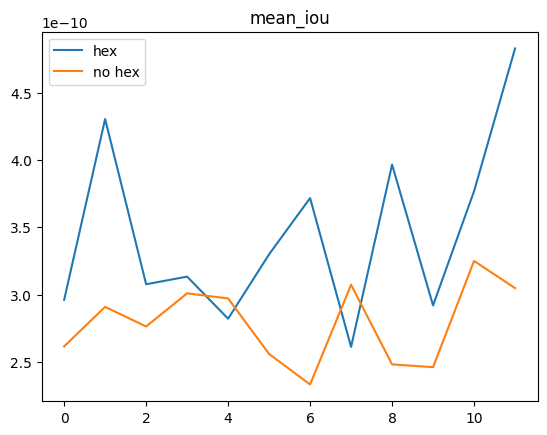

In [51]:


plt.plot(range(len(df[df['hex'] == 'yes'])), df[df['hex'] == 'yes']['mean_iou'], label = 'hex' )
plt.plot(range(len(df[df['hex'] != 'yes'])), df[df['hex'] != 'yes']['mean_iou'] , label = 'no hex')
plt.title('mean_iou')
plt.legend()

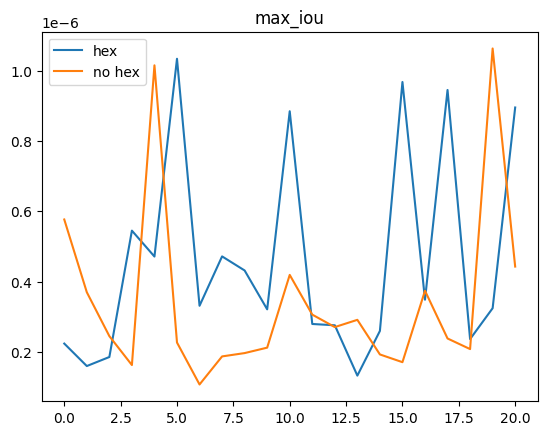

In [42]:


plt.plot(range(len(df[df['hex'] == 'yes'])), df[df['hex'] == 'yes']['max_iou'], label = 'hex' )
plt.plot(range(len(df[df['hex'] != 'yes'])), df[df['hex'] != 'yes']['max_iou'] , label = 'no hex')
plt.title('max_iou')
plt.legend()

In [43]:
df

,MODEL_VERSION,epoch,detected,mean_iou,max_iou,min_iou,precision,recall,mAP.0.5,hex
0,v_start_learn.pth.tar,0,0,2.339685e-10,5.764874e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,1,0,3.086328e-10,3.695198e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,2,0,1.922280e-10,2.446262e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,3,0,2.094880e-10,1.623629e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,4,0,2.894972e-10,1.015068e-06,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,5,0,1.712888e-10,2.264656e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,6,0,1.809314e-10,1.070999e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,7,0,2.059236e-10,1.869434e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,8,0,2.049786e-10,1.964114e-07,0.0,0.0,0.0,tensor(0.),no
0,v_start_learn.pth.tar,9,0,2.615949e-10,2.118884e-07,0.0,0.0,0.0,tensor(0.),no


In [ ]:
max_iou